In [2]:
import sys
import os
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
# average volume, top 10 levels
processed_dir = os.path.join(project_root, 'data', 'processed')
tickers = [name for name in os.listdir(processed_dir) if os.path.isdir(os.path.join(processed_dir, name))]
print(tickers)
time_col = 0

avg_diffs = {}
for ticker in tickers:
    ob_dir = os.path.join(processed_dir, ticker, 'orderbooks', 'scaled')
    if os.path.isdir(ob_dir):
        csv_files = [f for f in os.listdir(ob_dir) if f.endswith('.csv')]
        if csv_files:
            first_csv = sorted(csv_files)[0]
            csv_path = os.path.join(ob_dir, first_csv)
            df_ob = pl.read_csv(csv_path).to_pandas()
            # Compute the average difference between consecutive values in column 1
            col1 = df_ob.iloc[:, time_col]
            avg_diff = col1.diff().abs().mean()
            print(f"Ticker: {ticker}, Average Update difference: {avg_diff}")
            avg_diffs[ticker] = float(avg_diff)
        else:
            print(f"No CSV files found in {ob_dir}")
    else:
        print(f"Directory does not exist: {ob_dir}")
# del avg_diffs['AMZN']
# del avg_diffs['WFC']
    

['AAPL', 'CSCO', 'NFLX', 'NVDA', 'TSLA']
Ticker: AAPL, Average Update difference: 0.016324748125661145
Ticker: CSCO, Average Update difference: 0.04036218581027897
Ticker: NFLX, Average Update difference: 0.28448296189298344
Ticker: NVDA, Average Update difference: 0.008002265498323332
Ticker: TSLA, Average Update difference: 0.09110526379624949


In [4]:
print(avg_diffs)
avg_diffs_df = pd.DataFrame(list(avg_diffs.items()), columns=['Ticker', 'Average Update Difference'])
avg_diffs_df['updates_per_second'] = 1 / avg_diffs_df['Average Update Difference']

{'AAPL': 0.016324748125661145, 'CSCO': 0.04036218581027897, 'NFLX': 0.28448296189298344, 'NVDA': 0.008002265498323332, 'TSLA': 0.09110526379624949}


C:\Users\benhu\AppData\Local\Temp\ipykernel_25948\288676645.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ticker', y='updates_per_second', data=sorted_df, palette='viridis')


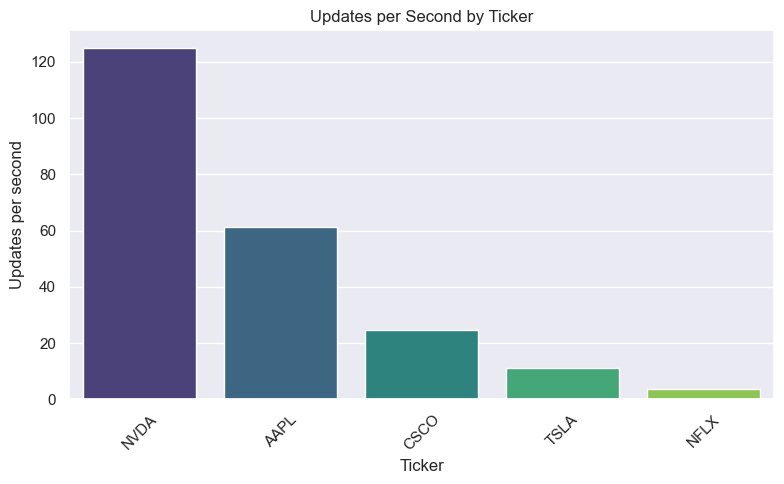

In [7]:
# bar plot of updates per second
sns.set()
plt.figure(figsize=(8, 5))
sorted_df = avg_diffs_df.sort_values('updates_per_second', ascending=False).reset_index(drop=True)
sns.barplot(x='Ticker', y='updates_per_second', data=sorted_df, palette='viridis')
plt.xlabel('Ticker')
plt.ylabel('Updates per second')
plt.title('Updates per Second by Ticker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
aapl_raw_file = rf'C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\data\processed\AAPL\orderbooks\unscaled\AAPL_orderbooks_2025-06-04.csv'
aapl_raw_books = pl.read_csv(aapl_raw_file, has_header=False).to_pandas()
# print(aapl_raw_books.columns)
aapl_raw_books.head


<bound method NDFrame.head of              column_1  column_2  column_3  column_4  column_5  column_6  \
0        34201.167489   2029600        10   2028500       143   2029700   
1        34201.167490   2029600        10   2028500       143   2029700   
2        34201.167502   2029600        10   2028500       143   2029700   
3        34201.167504   2029600        10   2028500       143   2029700   
4        34201.167506   2029600        10   2028500       143   2029700   
...               ...       ...       ...       ...       ...       ...   
1526286  57599.845456   2028100       100   2028000      1671   2028200   
1526287  57599.845487   2028100       200   2028000      1671   2028200   
1526288  57599.845892   2028100       200   2028000      1671   2028200   
1526289  57599.846047   2028100       200   2028000      1271   2028200   
1526290  57599.846547   2028100       200   2028000       104   2028200   

         column_7  column_8  column_9  column_10  ...  column_34  col

In [6]:
aapl_raw_books['mid'] = (aapl_raw_books['column_2'] + aapl_raw_books['column_2']) / (2 * 10_000)
aapl_raw_books['mid']

0          202.96
1          202.96
2          202.96
3          202.96
4          202.96
            ...  
1526286    202.81
1526287    202.81
1526288    202.81
1526289    202.81
1526290    202.81
Name: mid, Length: 1526291, dtype: float64

In [7]:
aapl_raw_books['returns'] =  aapl_raw_books['mid'].diff()

[]

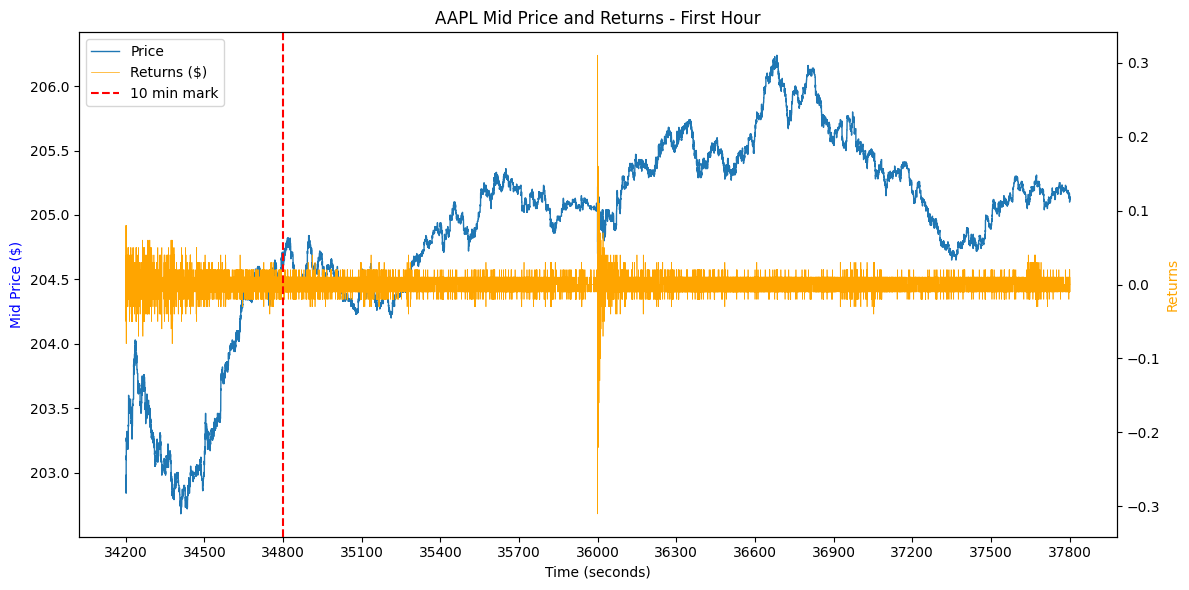

In [8]:
first_hour_time = aapl_raw_books['column_1'][0] + 60*60
ten_min_time = aapl_raw_books['column_1'][0] + 60*10
first_hour = aapl_raw_books[aapl_raw_books['column_1'] < first_hour_time]
fig = plt.figure(figsize=(12,6))
plt.plot(first_hour['column_1'], first_hour['mid'], label='Price', linewidth=1,)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(first_hour['column_1'], first_hour['returns'], color='orange', label='Returns ($)', linewidth=0.5, alpha=1)
ax2.set_ylabel('Returns', color='orange')
plt.axvline(x=ten_min_time, color='red', linestyle='--', label='10 min mark')
# Ensure both axes have the same number of ticks
ax1.locator_params(axis='x', nbins=10)
ax2.locator_params(axis='y', nbins=10)

# Set axis labels and title
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Mid Price ($)', color='blue')
plt.title('AAPL Mid Price and Returns - First Hour')

# Improve legend and layout
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.tight_layout()
ax1.xaxis.set_major_locator(plt.MultipleLocator(300))
plt.plot()

In [9]:
aapl_raw_msg_file = rf'C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\data\raw\AAPL_2025-06-04_34200000_57600000_message_10.csv'
aapl_raw_msg = pl.read_csv(aapl_raw_msg_file, has_header=False).to_pandas()
# print(aapl_raw_books.columns)
aapl_raw_msg.head

<bound method NDFrame.head of              column_1  column_2   column_3  column_4  column_5  column_6  \
0        34200.000792         4   34695565        20   2029700         1   
1        34200.000792         4   34803277       161   2029700         1   
2        34200.000792         4   33057753        19   2029100         1   
3        34200.000993         1   34939373       100   2030000        -1   
4        34200.002007         1   34940337       100   2029700        -1   
...               ...       ...        ...       ...       ...       ...   
1614500  57599.977844         1  608258953       300   2029300        -1   
1614501  57599.986777         3  608217861        18   2027700         1   
1614502  57599.987011         1  608261961       299   2027800         1   
1614503  57599.996272         1  608266665        60   2030000        -1   
1614504  57599.997518         1  608267273       900   2029100        -1   

        column_7  
0           null  
1           null  


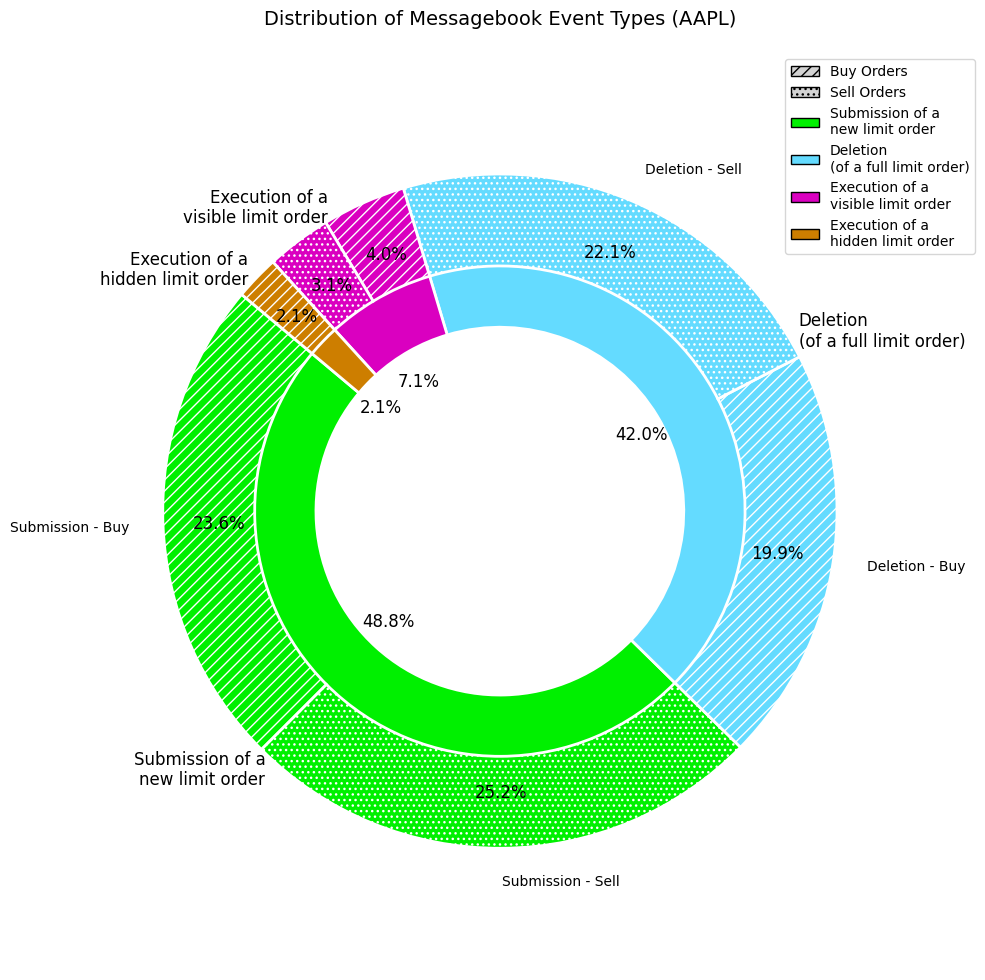


Summary Statistics:
Submission of a new limit order:
  Total: 787,151 (48.8%)
  Buy:   381,116 (48.4%)
  Sell:  406,035 (51.6%)

Deletion (of a full limit order):
  Total: 677,516 (42.0%)
  Buy:   321,499 (47.5%)
  Sell:  356,017 (52.5%)

Execution of a visible limit order:
  Total: 115,208 (7.1%)
  Buy:   64,873 (56.3%)
  Sell:  50,335 (43.7%)

Execution of a hidden limit order:
  Total: 34,341 (2.1%)
  Buy:   34,341 (100.0%)
  Sell:  0 (0.0%)



In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count message types and trade directions
msg_counts = aapl_raw_msg.groupby(['column_2', 'column_6']).size().unstack(fill_value=0)

# Focus on main message types
main_labels = [1, 3, 4, 5]
main_counts = msg_counts.loc[main_labels]

# Buy/sell counts (assuming 1=buy, -1=sell)
buy_counts = main_counts.get(1, pd.Series([0]*len(main_counts), index=main_counts.index))
sell_counts = main_counts.get(-1, pd.Series([0]*len(main_counts), index=main_counts.index))

# Total counts for inner ring
total_counts = main_counts.sum(axis=1)

# Labels for display
main_labels_text = [
    "Submission of a\nnew limit order",
    "Deletion\n(of a full limit order)", 
    "Execution of a\nvisible limit order",
    "Execution of a\nhidden limit order"
]

# Base colors for each message type
# base_colors = sns.color_palette('viridis', len(main_labels))
base_colors = ["#00F000", "#64dbff", "#DA00C0", "#cd7e00"]

# Create nested pie chart
fig, ax = plt.subplots(figsize=(10, 10))

# Inner ring - Total counts by message type
wedges_inner, texts_inner, autotexts_inner = ax.pie(
    total_counts.values,
    labels=main_labels_text,
    autopct='%1.1f%%',
    startangle=140,
    radius=0.9,
    colors=base_colors,
    wedgeprops=dict(width=0.3, edgecolor='white', linewidth=2)
)

# Prepare data for outer ring - buy/sell breakdown
outer_colors = [c for c in base_colors for _ in range(2)]
outer_sizes = []
outer_labels = []

for i, (msg_type, color) in enumerate(zip(main_labels, base_colors)):
    buy_count = buy_counts.iloc[i]
    sell_count = sell_counts.iloc[i]
    
    # For the last 3 labels, set outer_labels to empty string
    if i >= len(main_labels) - 2:
        if buy_count > 0:
            outer_sizes.append(buy_count)
            outer_labels.append("")
        if sell_count > 0:
            outer_sizes.append(sell_count)
            outer_labels.append("")
    else:
        if buy_count > 0:
            outer_sizes.append(buy_count)
            outer_labels.append(f"{main_labels_text[i].split()[0]} - Buy")
        if sell_count > 0:
            outer_sizes.append(sell_count)
            outer_labels.append(f"{main_labels_text[i].split()[0]} - Sell")

# Outer ring - Buy/sell breakdown
wedges_outer, texts_outer, autotexts_outer = ax.pie(
    outer_sizes,
    labels=outer_labels,
    autopct='%1.1f%%',
    startangle=140,
    radius=1.1,
    colors=outer_colors,
    wedgeprops=dict(width=0.3, edgecolor='white', linewidth=2)
)

# Move outer percentages closer to the edge
for t in autotexts_outer:
    t.set_fontsize(12)
    t.set_color('black')
    t.set_position((t.get_position()[0]*1.39, t.get_position()[1]*1.39))

# Add patterns to distinguish buy/sell
pattern_index = 0
for i, (msg_type, _) in enumerate(zip(main_labels, base_colors)):
    buy_count = buy_counts.iloc[i]
    sell_count = sell_counts.iloc[i]
    
    if buy_count > 0:
        wedges_outer[pattern_index].set_hatch('///')  # Buy pattern
        pattern_index += 1
    
    if sell_count > 0:
        wedges_outer[pattern_index].set_hatch('...')  # Sell pattern
        pattern_index += 1

# Create custom legend
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='lightgray', edgecolor='black', hatch='///', label='Buy Orders'),
    plt.Rectangle((0,0),1,1, facecolor='lightgray', edgecolor='black', hatch='...', label='Sell Orders')
]

# Add message type legend
for i, (label, color) in enumerate(zip(main_labels_text, base_colors)):
    legend_elements.append(
        plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='black', label=label)
    )

# Make pie chart text large and grey, and move labels slightly away from the pie chart
for t in texts_inner:
    t.set_fontsize(12)
    t.set_color('black')
    t.set_position((t.get_position()[0]*1.15, t.get_position()[1]*1.15))  # Move label outward

for t in autotexts_inner:
    t.set_fontsize(12)
    t.set_color('black')
    t.set_position((t.get_position()[0]*1, t.get_position()[1]*0.9))  # Move percentage outward

plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1.0))
plt.title("Distribution of Messagebook Event Types (AAPL)", 
          fontsize=14, pad=20)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 50)
for i, msg_type in enumerate(main_labels):
    label = main_labels_text[i].replace('\n', ' ')
    total = total_counts.iloc[i]
    buy = buy_counts.iloc[i]
    sell = sell_counts.iloc[i]
    buy_pct = (buy/total)*100 if total > 0 else 0
    sell_pct = (sell/total)*100 if total > 0 else 0
    
    print(f"{label}:")
    print(f"  Total: {total:,} ({total/total_counts.sum()*100:.1f}%)")
    print(f"  Buy:   {buy:,} ({buy_pct:.1f}%)")
    print(f"  Sell:  {sell:,} ({sell_pct:.1f}%)")
    print()

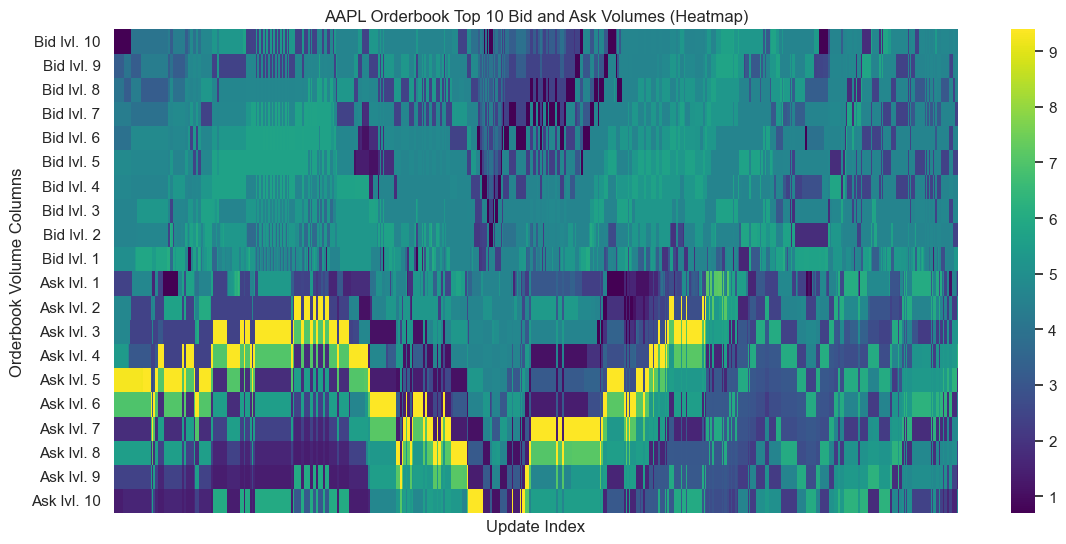

In [ ]:
aapl_raw_books_short = aapl_raw_books[:1_000]
ask_vol_cols = [f'column_{4*i + 3}' for i in range(10)]
bid_vol_cols = [f'column_{4*i + 5}' for i in reversed(range(10))]

bid_labels = [f"Bid lvl. {i}" for i in reversed(range(1,11))]
ask_labels = [f"Ask lvl. {i}" for i in range(1,11)]
y_labels = bid_labels + ask_labels

cols = bid_vol_cols + ask_vol_cols
aapl_raw_books_log_vol = np.log1p(aapl_raw_books_short[cols])
# aapl_raw_books_log_vol = np.log1p(aapl_raw_books_short[cols])

plt.figure(figsize=(12, 6))
sns.heatmap(aapl_raw_books_log_vol[cols].T, cmap='viridis', cbar=True)
plt.xlabel('Update Index')
plt.ylabel('Orderbook Volume Columns')
plt.title('AAPL Orderbook Top 10 Bid and Ask Volumes (Heatmap)')
plt.tight_layout()
plt.xticks([])

# Set y-axis labels to levels
plt.yticks(
    ticks=np.arange(len(cols)) + 0.5,
    labels=y_labels,
    rotation=0
)
plt.show()


plt.show()

['column_41', 'column_37', 'column_33', 'column_29', 'column_25', 'column_21', 'column_17', 'column_13', 'column_9', 'column_5', 'column_3', 'column_7', 'column_11', 'column_15', 'column_19', 'column_23', 'column_27', 'column_31', 'column_35', 'column_39']
['Bid lvl. 10', 'Bid lvl. 9', 'Bid lvl. 8', 'Bid lvl. 7', 'Bid lvl. 6', 'Bid lvl. 5', 'Bid lvl. 4', 'Bid lvl. 3', 'Bid lvl. 2', 'Bid lvl. 1', 'Ask lvl. 1', 'Ask lvl. 2', 'Ask lvl. 3', 'Ask lvl. 4', 'Ask lvl. 5', 'Ask lvl. 6', 'Ask lvl. 7', 'Ask lvl. 8', 'Ask lvl. 9', 'Ask lvl. 10']
0       17.131910
1       17.131910
2       17.131910
3       17.131910
4       17.131910
          ...    
2995     3.201668
2996     3.088973
2997     2.976278
2998     2.863583
2999     2.750887
Length: 3000, dtype: float64


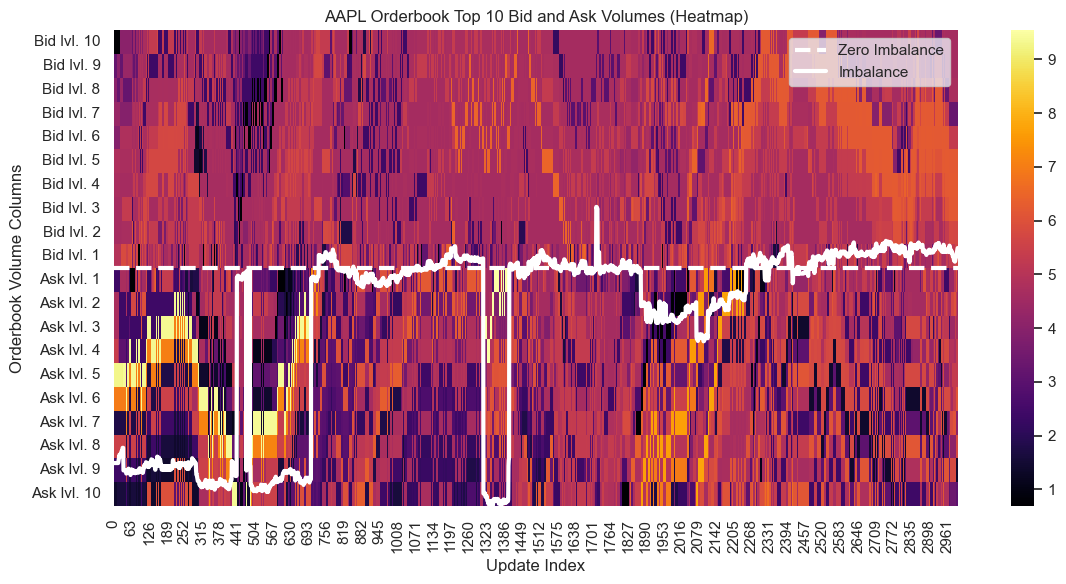

In [182]:
aapl_raw_books_short = aapl_raw_books[:3_000]
ask_vol_cols = [f'column_{4*i + 3}' for i in range(10)]
bid_vol_cols = [f'column_{4*i + 5}' for i in reversed(range(10))]

bid_labels = [f"Bid lvl. {i}" for i in reversed(range(1,11))]
ask_labels = [f"Ask lvl. {i}" for i in range(1,11)]
y_labels = bid_labels + ask_labels

cols = bid_vol_cols + ask_vol_cols
print(cols)
print(y_labels)
aapl_raw_books_log_vol = np.log1p(aapl_raw_books_short[cols])
# aapl_raw_books_log_vol = np.log1p(aapl_raw_books_short[cols])


# Calculate total bid and ask volume for each update
total_bid_vol = aapl_raw_books_short[bid_vol_cols].sum(axis=1)
total_ask_vol = aapl_raw_books_short[ask_vol_cols].sum(axis=1)
imbalance = total_bid_vol - total_ask_vol

plt.figure(figsize=(12, 6))
sns.heatmap(aapl_raw_books_log_vol[cols].T, cmap='inferno', cbar=True)
plt.xlabel('Update Index')
plt.ylabel('Orderbook Volume Columns')
plt.title('AAPL Orderbook Top 10 Bid and Ask Volumes (Heatmap)')
plt.tight_layout()
plt.xticks()

plt.yticks(
    ticks=np.arange(len(cols)) + 0.5,
    labels=y_labels,
    rotation=0
)

# Overplot imbalance as a line (scaled for visibility)
imbalance_scaled = (imbalance.max() - imbalance) / (imbalance.max() - imbalance.min()) * len(cols)
print(imbalance_scaled)
# Center imbalance at zero, scale so that the halfway point is zero and the limits are +/- abs max
abs_max = np.abs(imbalance).max()
imbalance_centered = -imbalance / abs_max * (len(cols) / 2)
plt.axhline(y=len(cols) / 2, color='white', linestyle='--', linewidth=3, label='Zero Imbalance')
plt.plot(imbalance_centered + (len(cols) / 2), color='white', label='Imbalance', linewidth=3)
plt.legend(loc='upper right')
plt.show()


In [1]:
from mplfinance.original_flavor import candlestick_ohlc

# Bucket into 3-minute windows (180 seconds)
aapl_raw_books['window'] = (aapl_raw_books['column_1'] // 180).astype(int)

# Aggregate OHLC for each window
ohlc = aapl_raw_books.groupby('window')['mid'].agg(['first', 'max', 'min', 'last']).rename(
    columns={'first': 'Open', 'max': 'High', 'min': 'Low', 'last': 'Close'}
)

# Create time index for plotting
ohlc['time'] = ohlc.index * 1800 + aapl_raw_books['column_1'].min()

import matplotlib.dates as mdates

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 8))
ohlc_plot = ohlc[['time', 'Open', 'High', 'Low', 'Close']]
ohlc_plot['time'] = pd.to_datetime(ohlc_plot['time'], unit='s')
ohlc_plot['time_num'] = mdates.date2num(ohlc_plot['time'])

candlestick_ohlc(
    ax,
    ohlc_plot[['time_num', 'Open', 'High', 'Low', 'Close']].values,
    width=0.02,
    colorup='#00ff99',
    colordown='#ff3366',
    alpha=0.9
)
ax.xaxis_date()
ax.set_xlabel('Time', fontsize=14, color='white')
ax.set_ylabel('Mid Price ($)', fontsize=14, color='white')
plt.title('AAPL 3-Minute Candlestick Chart', fontsize=18, color='white')
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

NameError: name 'aapl_raw_books' is not defined